### Please install the required Python modules/SDKs

In [1]:
! activate ai-azure-c1

import sys

sys.path.append("/opt/conda/envs/ai-azure-c1/lib/python3.8/site-packages")

# Azure Custom Vision - Object Detection

## Import utility functions and Python modules 

In [1]:
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os, time, uuid

In [2]:
def show_image_in_cell(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()

In [4]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials


### Resources:
- Azure Custom Vision Endpoint
- Training Reource ID and Key
- Prediction Resource ID and Key

## Make sure you have the correct Training and Prediction Endpoints, Keys and Resource IDs separately

### Your Training Endpoint resource must be for both training and prediction

In [32]:
TRAINING_ENDPOINT = "https://kiosklighterdetection.cognitiveservices.azure.com/"
training_key = "1a85408a3aeb42fdb3b36ca4fe6bb61f"
training_resource_id = 'bfb98fcd-9467-4bc4-979a-74ff0e950a1f'

In [79]:
PREDICTION_ENDPOINT = 'https://kiosklighterdetection-prediction.cognitiveservices.azure.com/'
prediction_key = "504a2ca1b11049678c06f25976167344"
prediction_resource_id = "/subscriptions/bfb98fcd-9467-4bc4-979a-74ff0e950a1f/resourceGroups/Veritapp/providers/Microsoft.CognitiveServices/accounts/kiosklighterdetection"

## Instantiate and authenticate the training client with endpoint and key 

In [56]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(TRAINING_ENDPOINT, training_credentials)

In [57]:
trainer.api_version

'3.4-preview'

## Instantiate and authenticate the prediction client with endpoint and key

In [80]:
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(PREDICTION_ENDPOINT, prediction_credentials)

In [81]:
predictor.api_version

'3.1'

## Creating Training Project First

In [38]:
# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Create a new project
print ("Your Object Detection Training project has been created. Please move on.")
project_name = uuid.uuid4()
project = trainer.create_project(project_name, domain_id=obj_detection_domain.id)

Your Object Detection Training project has been created. Please move on.


## Getting Project Details as collective information 

In [39]:
project.as_dict()

{'id': '052381e8-dfa1-455a-b8b0-2921cd789e98',
 'name': '91cedcd6-2eb5-4486-b169-041ff0514110',
 'description': '',
 'settings': {'domain_id': 'da2e3a8a-40a5-4171-82f4-58522f70fbc1',
  'classification_type': 'Multilabel',
  'target_export_platforms': [],
  'use_negative_set': True,
  'image_processing_settings': {'augmentation_methods': {'rotation': True,
    'scaling': True,
    'translation': True,
    'horizontal flip': True,
    'equalize': True,
    'solarize': True,
    'padtosquare': True}}},
 'created': '2023-05-29T09:51:03.336Z',
 'last_modified': '2023-05-29T09:51:03.336Z',
 'dr_mode_enabled': False,
 'status': 'Succeeded'}

In [40]:
project.status

'Succeeded'

## Adding Tags based on training requirements
  
- In the demo, we used images and tags for Bird and Flower. For this exercise, you can use the "bottle" tag or any other class/type of your own images.
- Please modify the code accordingly.

In [ ]:
bird_tag = trainer.create_tag(project.id, "Bird")

In [ ]:
flower_tag = trainer.create_tag(project.id, "Flower")

# VERY IMPORTANT - PAUSE HERE
# Now, please go to the Custom Vision portal, upload and label your training images
## Please read the following instructions:

- Please visit the Custom Vision Portal (https://computervision.api) and upload all your training images manually. 
- After that, you can label the tag region for each object directly at the portal. 
- This way, you don't need to use any third-party website or service to generate tag regions in the form of bounding box coordinates. If you have training images with those coordinates, you can use the optional section in the demo Jupyter Notebook to upload your images with the tagged objects via code.

### Once you have uploaded and labeled all the training images at the portal, you can come back to this notebook and start the training process. 

## Start the Object Detection Training
- We will keep checking every 10 seconds during the training progress

In [ ]:
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    print ("Waiting 10 seconds...")
    time.sleep(10)

## After training is complete, we will check model performance

In [ ]:
iteration.as_dict()

In [ ]:
iteration_list = trainer.get_iterations(project.id)
for iteration_item in iteration_list:
    print(iteration_item)

In [ ]:
model_perf = trainer.get_iteration_performance(project.id, iteration_list[0].id)

In [ ]:
model_perf.as_dict()

## Publishing the Model to the Project Endpoint

In [ ]:
## Setting the Iteration Name, this will be used when Model training is completed
publish_iteration_name = "udacity-2-classes-object-detection-custom"

In [ ]:
# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)
print ("Done!")

## Performing Prediction
- Using the predictor object 

In [6]:
local_image_path = '/home/workspace'

In [7]:
!ls $local_image_path

ls: /home/workspace: No such file or directory


In [9]:
current_directory = os.getcwd()


In [11]:
test_images_path = '/Users/financialanalyst/AI-Enginear-Azure/cd0461-building-computer-vision-solutions-with-azure-project-starter/starter/lighter_test_images'

In [12]:
files = os.listdir(test_images_path)

In [13]:
files

['lighter_test_set_5of5.jpg',
 'lighter_test_set_3of5.jpg',
 'lighter_test_set_1of5.jpg',
 'lighter_test_set_4of5.jpg',
 'lighter_test_set_2of5.jpg']

In [65]:
project_id = '047b9ac6-636c-4a3c-9550-b805b81fa092'
publish_iteration_name = 'Iteration1'

In [82]:
def perform_prediction(image_file_name):
    with open(os.path.join (test_images_path,  image_file_name), "rb") as image_contents:
        results = predictor.detect_image(project_id, publish_iteration_name, image_contents.read())
        # Display the results.
        for prediction in results.predictions:
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))

In [83]:
perform_prediction(files[0])

	lighter: 99.76%
	lighter: 36.84%
	lighter: 2.54%
	lighter: 1.88%
	lighter: 1.27%
	lighter: 1.21%
	lighter: 1.15%


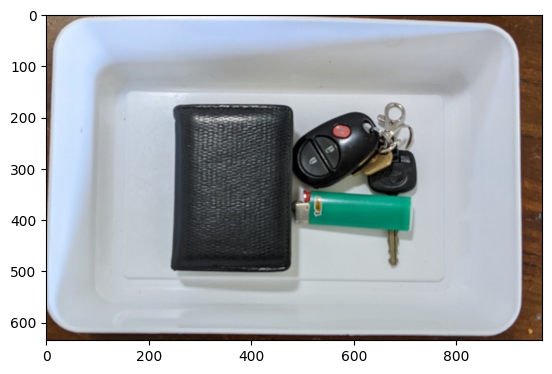

In [73]:
## Checking the Image
with open(os.path.join (test_images_path, file_name_2), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)

## Exporting Model 
Note: This code is exact same as the Image classification model export. You just need to have the proper project ID and iteration ID specific to any custom vision solution, and the respective model from the selected iteration will be exported to the target platform and flavor. 

In [1]:
platform = "TensorFlow"
flavor = "TensorFlowLite"

### Using the export_iteration method

In [ ]:
export_process = trainer.export_iteration(project.id, iteration.id, platform, flavor, raw=True)

In [ ]:
print(export_process.output)

In [ ]:
print(export_process.output.status)

In [ ]:
### Code snippet is from Azure SDK and Documentation
### https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/export-programmatically
### This step may take long time 
while (export_process.output.status == "Exporting"):
    print ("Waiting 10 seconds...")
    time.sleep(10)
    exports = trainer.get_exports(project_id, selected_iteration_id)
    for e in exports:
        if e.platform == export_process.output.platform and e.flavor == export_process.output.flavor:
            export = e
            break
    print("Export status is: ", export_process.output.status)

In [ ]:
print(export_process.output.status)

In [ ]:
print(export_process.output.download_uri)

### You can choose any preferred name of the file download as exported model

In [ ]:
## Downloading the model from url
if export_process.output.status == "Done":
    # Ready to Download
    model_export_file = requests.get(export_process.output.download_uri)
    with open("od_model_tensorflow.zip", "wb") as file:
        file.write(model_export_file.content)